<center> <font size="6"> <div class="alert alert-block alert-success"> <strong> A2Z Insurance Customer Segmentation Project 
</strong> </div> </font> </center>

<center> <font size="4"> <div class="alert alert-block alert-success"> <strong> Density Clustering
</strong> </div> </font> </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

#!pip install sas7bdat

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import ceil

from sklearn.impute import KNNImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver
plt.rcParams['figure.dpi'] = 50

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

In [2]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

## Import Data

In [3]:
#import pre-proc dataset
df_ohc=pd.read_csv('preproc_data.csv')
df_ohc = df_ohc.rename(columns={"x0_b'2 - High School'":'High School', 
                              "x0_b'3 - BSc/MSc'":'BSc/MSc', 
                              "x0_b'4 - PhD'":'PhD', 
                              'x1_Diamond':'Diamond', 
                              'x1_Gold':'Gold', 
                              'x1_Silver':'Silver',
                              })

In [4]:
#define perspectives
demo =  df_ohc[['High School', 'BSc/MSc', 'PhD',
       'MonthSal','GeoLivArea', 'Children']].copy()

cust_val =  df_ohc[['CustMonVal','Client Tenure', 'Total Premium']].copy()

## Density Clustering

### Perspective 1: Customer Value

#### Mean Shift Clustering

In [5]:
bandwidth = estimate_bandwidth(cust_val, quantile=0.30, random_state=1, n_jobs=-1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(cust_val)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 5


In [6]:
df_concat_ms = pd.concat([cust_val, pd.Series(ms_labels, index=cust_val.index, name="ms_labels")], axis=1)
df_concat_ms.groupby('ms_labels').mean()

,CustMonVal,Client Tenure,Total Premium
ms_labels,,,
0,0.891270,0.421776,0.176713
1,0.300509,0.179487,0.161159
2,0.883831,0.864733,0.131542
3,0.883556,0.967289,0.137011
4,0.000000,0.692308,0.094871


#### DBSCAN (Density-based spatial clustering of applications with noise)

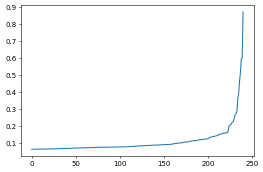

In [7]:
neigh = NearestNeighbors(n_neighbors=27)
neigh.fit(cust_val)
distances, _ = neigh.kneighbors(cust_val)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

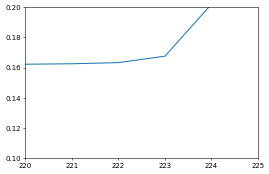

In [8]:
plt.plot(distances[10000:])
plt.axis([220, 225, 0.1, 0.2])
plt.show()

In [9]:
dbscan = DBSCAN(eps=0.17, n_jobs=4)
dbscan_labels = dbscan.fit_predict(cust_val)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [10]:
df_concat_dbscan = pd.concat([cust_val, pd.Series(dbscan_labels, index=cust_val.index, name="dbscan_labels")], axis=1)
df_concat_dbscan.head()

,CustMonVal,Client Tenure,Total Premium,dbscan_labels
0,0.900222,0.576923,0.126701,0
1,0.869682,0.192308,0.251557,0
2,0.907599,0.346154,0.164880,0
3,0.876488,0.384615,0.093691,0
4,0.879603,0.538462,0.108222,0


In [11]:
df_concat_dbscan.loc[df_concat_dbscan['dbscan_labels'] == -1]

,CustMonVal,Client Tenure,Total Premium,dbscan_labels
51,0.000000,0.692308,0.094871,-1
112,0.357525,0.115385,0.090012,-1
135,0.269271,0.115385,0.163170,-1
752,0.274730,0.307692,0.230294,-1
787,0.409282,0.653846,0.096743,-1
974,0.512772,0.423077,0.137446,-1
8380,0.873844,0.153846,1.000000,-1


#### GMM (Gaussian Mixture Model )

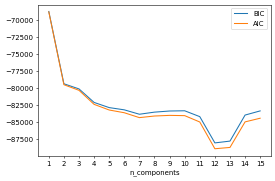

In [12]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(cust_val)
          for n in n_components]

bic_values = [m.bic(cust_val) for m in models]
aic_values = [m.aic(cust_val) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [13]:
gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(cust_val)
labels_proba = gmm.predict_proba(cust_val)

In [14]:
print('Estimated Weights:', gmm.weights_)
print()

print('Estimated Mean Vectors:', gmm.means_)
print()

print('Estimated Covariance Matrix Components:', gmm.covariances_.shape)

Estimated Weights: [0.8650579 0.1349421]

Estimated Mean Vectors: [[0.88898145 0.49942353 0.14245519]
 [0.897538   0.3280898  0.35845966]]

Estimated Covariance Matrix Components: (2, 3, 3)


In [15]:
df_concat_gmm = pd.concat([cust_val, pd.Series(gmm_labels, index=cust_val.index, name="gmm_labels")], axis=1)
df_concat_gmm.head()
df_concat_gmm.groupby('gmm_labels').describe().T

gmm_labels                     0            1
CustMonVal    count  8991.000000  1250.000000
              mean      0.888985     0.898416
              std       0.012695     0.050154
              min       0.852649     0.000000
              25%       0.876886     0.878205
              50%       0.888133     0.900466
              75%       0.900016     0.921733
              max       0.926473     1.000000
Client Tenure count  8991.000000  1250.000000
              mean      0.497599     0.323126
              std       0.245952     0.231633
              min       0.000000     0.000000
              25%       0.307692     0.153846
              50%       0.461538     0.269231
              75%       0.692308     0.423077
              max       1.000000     1.000000
Total Premium count  8991.000000  1250.000000
              mean      0.143199     0.375906
              std       0.054041     0.095170
              min       0.000000     0.077628
              25%       0.102592     0.309411
              50%       0.133824     0.352823
              75%       0.177729     0.416835
              max       0.312896     1.000000

### Perspective 2: Customer Demography

#### Mean Shift Clustering

In [16]:
bandwidth = estimate_bandwidth(demo, quantile=0.20, random_state=1, n_jobs=-1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(demo)
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 8


In [17]:
df_concat_ms2 = pd.concat([demo, pd.Series(ms_labels, index=demo.index, name="ms_labels2")], axis=1)
df_concat_ms2.head()

,High School,BSc/MSc,PhD,MonthSal,GeoLivArea,Children,ms_labels2
0,1.0,0.0,0.0,0.393345,0.000000,1.0,1
1,1.0,0.0,0.0,0.073379,1.000000,1.0,1
2,0.0,0.0,0.0,0.414676,0.666667,0.0,6
3,0.0,1.0,0.0,0.163396,1.000000,1.0,0
4,0.0,1.0,0.0,0.305034,1.000000,1.0,0


#### DBSCAN (Density-based spatial clustering of applications with noise)

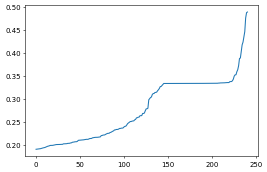

In [18]:
neigh = NearestNeighbors(n_neighbors=27)
neigh.fit(demo)
distances, _ = neigh.kneighbors(demo)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

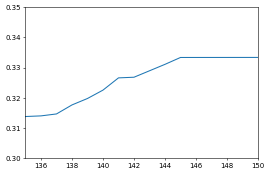

In [19]:
plt.plot(distances[10000:])
plt.axis([135, 150, 0.30, 0.35])
plt.show()

In [20]:
dbscan = DBSCAN(eps=0.32, n_jobs=4)
dbscan_labels = dbscan.fit_predict(demo)
dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 33


In [21]:
df_concat_dbscan2 = pd.concat([demo, pd.Series(dbscan_labels, index=demo.index, name="dbscan_labels2")], axis=1)
df_concat_dbscan2.head()

,High School,BSc/MSc,PhD,MonthSal,GeoLivArea,Children,dbscan_labels2
0,1.0,0.0,0.0,0.393345,0.000000,1.0,0
1,1.0,0.0,0.0,0.073379,1.000000,1.0,1
2,0.0,0.0,0.0,0.414676,0.666667,0.0,2
3,0.0,1.0,0.0,0.163396,1.000000,1.0,3
4,0.0,1.0,0.0,0.305034,1.000000,1.0,3


In [22]:
df_concat_dbscan2.loc[df_concat_dbscan2['dbscan_labels2'] == -1]

,High School,BSc/MSc,PhD,MonthSal,GeoLivArea,Children,dbscan_labels2
295,0.0,0.0,1.0,0.694966,0.533333,0.4,-1


#### GMM (Gaussian Mixture Model )

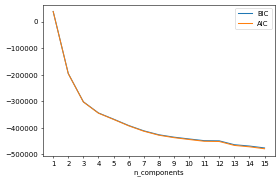

In [23]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(demo)
          for n in n_components]

bic_values = [m.bic(demo) for m in models]
aic_values = [m.aic(demo) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [24]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(demo)
labels_proba = gmm.predict_proba(demo)

In [25]:
print('Estimated Weights:', gmm.weights_)
print()

print('Estimated Mean Vectors:', gmm.means_)
print()

print('Estimated Covariance Matrix Components:', gmm.covariances_.shape)

Estimated Weights: [0.13641246 0.34127527 0.33258471 0.18972757]

Estimated Mean Vectors: [[0.         1.         0.         0.64675621 0.57981389 0.        ]
 [1.         0.         0.         0.46003572 0.57901764 0.70758226]
 [0.         1.         0.         0.4221085  0.55911137 0.99982384]
 [0.         0.         0.35923829 0.40678754 0.56400755 0.70386001]]

Estimated Covariance Matrix Components: (4, 6, 6)


In [26]:
df_concat_gmm2 = pd.concat([demo, pd.Series(gmm_labels, index=demo.index, name="gmm_labels2")], axis=1)
df_concat_gmm2.head()
df_concat_gmm2.groupby('gmm_labels2').describe().T

gmm_labels2                  0            1            2            3
High School count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      0.000000     1.000000     0.000000     0.000000
            std       0.000000     0.000000     0.000000     0.000000
            min       0.000000     1.000000     0.000000     0.000000
            25%       0.000000     1.000000     0.000000     0.000000
            50%       0.000000     1.000000     0.000000     0.000000
            75%       0.000000     1.000000     0.000000     0.000000
            max       0.000000     1.000000     0.000000     0.000000
BSc/MSc     count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      1.000000     0.000000     1.000000     0.000000
            std       0.000000     0.000000     0.000000     0.000000
            min       1.000000     0.000000     1.000000     0.000000
            25%       1.000000     0.000000     1.000000     0.000000
            50%       1.000000     0.000000     1.000000     0.000000
            75%       1.000000     0.000000     1.000000     0.000000
            max       1.000000     0.000000     1.000000     0.000000
PhD         count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      0.000000     0.000000     0.000000     0.359238
            std       0.000000     0.000000     0.000000     0.479901
            min       0.000000     0.000000     0.000000     0.000000
            25%       0.000000     0.000000     0.000000     0.000000
            50%       0.000000     0.000000     0.000000     0.000000
            75%       0.000000     0.000000     0.000000     1.000000
            max       0.000000     0.000000     0.000000     1.000000
MonthSal    count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      0.646756     0.460036     0.422108     0.406788
            std       0.174912     0.210018     0.161937     0.230597
            min       0.010026     0.000000     0.006826     0.000000
            25%       0.585751     0.283596     0.301621     0.204032
            50%       0.687287     0.463097     0.418089     0.394411
            75%       0.764078     0.632786     0.542555     0.595030
            max       0.994454     1.000000     0.970563     0.968217
GeoLivArea  count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      0.579814     0.579018     0.559111     0.564008
            std       0.421217     0.422125     0.421962     0.423307
            min       0.000000     0.000000     0.000000     0.000000
            25%       0.000000     0.000000     0.000000     0.000000
            50%       0.666667     0.666667     0.666667     0.666667
            75%       1.000000     1.000000     1.000000     1.000000
            max       1.000000     1.000000     1.000000     1.000000
Children    count  1397.000000  3495.000000  3406.000000  1943.000000
            mean      0.000000     0.707582     0.999824     0.703860
            std       0.000000     0.454636     0.005934     0.456220
            min       0.000000     0.000000     0.800000     0.000000
            25%       0.000000     0.000000     1.000000     0.000000
            50%       0.000000     1.000000     1.000000     1.000000
            75%       0.000000     1.000000     1.000000     1.000000
            max       0.000000     1.000000     1.000000     1.000000

## Evaluation

### Perspective 1: Customer Value

#### Mean Shift Clustering

* R^2

In [27]:
sst = get_ss(cust_val)  
ssw_labels = df_concat_ms.groupby(by='ms_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)


Cluster solution with R^2 of 0.3192


* Silhouette Score

In [28]:
silhouette_msc= silhouette_score(df_concat_ms, df_concat_ms['ms_labels'])
silhouette_msc

0.7821017212447997

#### DBSCAN

* R^2

In [29]:
df_nonoise = df_concat_dbscan.loc[df_concat_dbscan['dbscan_labels'] != -1]
sst = get_ss(cust_val)  
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)


Cluster solution with R^2 of 0.0046


* Silhouette Score

In [30]:
silhouette_dbscan= silhouette_score(df_concat_dbscan, df_concat_dbscan['dbscan_labels'])
silhouette_dbscan

0.7396424034000307

#### GMM

* R^2 

In [31]:
sst = get_ss(cust_val)  
ssw_labels = df_concat_gmm.groupby(by='gmm_labels').apply(get_ss) 
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1246


* Silhouette Score

In [32]:
silhouette_gmm= silhouette_score(df_concat_gmm, df_concat_gmm['gmm_labels'])
silhouette_gmm

0.7282147242868111

### Perspective 2: Customer Demography

#### Mean Shift Clustering

* R^2 

In [33]:
sst = get_ss(demo)  
ssw_labels = df_concat_ms2.groupby(by='ms_labels2').apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.7819


* Silhouette Score

In [34]:
silhouette_msc2= silhouette_score(df_concat_ms2, df_concat_ms2['ms_labels2'])
silhouette_msc2

0.6890422978656705

#### DBSCAN

* R^2 

In [35]:
df_nonoise = df_concat_dbscan2.loc[df_concat_dbscan2['dbscan_labels2'] != -1]
sst = get_ss(demo)  
ssw_labels = df_nonoise.groupby(by='dbscan_labels2').apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)


Cluster solution with R^2 of 0.9664


* Silhouette Score

In [36]:
silhouette_dbscan2= silhouette_score(df_concat_dbscan2, df_concat_dbscan2['dbscan_labels2'])
silhouette_dbscan2

0.8682080223244842

#### GMM

* R^2 

In [37]:
sst = get_ss(demo)  
ssw_labels = df_concat_gmm2.groupby(by='gmm_labels2').apply(get_ss) 
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.6172


* Silhouette Score

In [38]:
silhouette_gmm2= silhouette_score(df_concat_gmm2, df_concat_gmm2['gmm_labels2'])
silhouette_gmm2

0.5908755448531401